# Methodology Document for Reserve Fund Decay Simulation

### Introduction
This document describes the methodology used in the `reserve_fund_decay_sim.ipynb` notebook to simulate the financial decay of a reserve fund over time, focusing on the simulations conducted in cell 20. The notebook utilizes Python libraries to fetch data, process it, and perform simulations to assess the impact of different financial parameters on the reserve fund's sustainability.

### Data Collection
It fetches the balance of a specified Reserve Fund wallet, covering both ETH and various tokens, and retrieves current token prices to calculate their USD values.

### Data Processing
Data processing involves refining the list of wallet tokens and their values, extracting details like token address, symbol, decimals, balance, and price. This processed data helps compute the total USD value of the reserve fund.

### Simulation Functions

The simulation functions in the notebook are designed to project how the reserve fund and collateral behave under certain financial conditions, using three main functions that simulate exponential decay, linear decay, and conduct sensitivity analysis.

#### Exponential Decay Simulation
The function `simulate_financial_assumptions_exponential_decay` simulates the decay of a reserve fund under an exponential model, where the decrease in collateral is proportional to its current amount. Parameters include:
- `collateral`: Initial size of the short position in the futures market.
- `reserve_funds`: Available insurance funds.
- `negative_rate`: Assumed negative funding rate applied annually to the collateral.
- `slippage_loss`: Loss incurred from market slippage when the collateral is sold.
- `daily_redemption_rate`: Daily rate at which the collateral is sold off.

The simulation iterates daily, adjusting the reserve funds by the interest accrued at the negative rate and reducing it further by the slippage loss incurred from selling the collateral. The collateral itself decreases exponentially, factoring in the daily redemption rate. The state of the fund and collateral is recorded daily, and the simulation continues until either the collateral or reserve funds are depleted or the specified limit of days is reached.

#### Linear Decay Simulation
The `simulate_financial_assumptions_linear_decay` function employs a linear model for the decay of the collateral, where a fixed amount of collateral is redeemed daily. The parameters are identical to those in the exponential decay function. The difference lies in the handling of the collateral, which is reduced by a constant amount each day, determined by the initial collateral and the daily redemption rate. This function also calculates daily interest and slippage loss, updating the reserve funds accordingly, and records the daily status until depletion or the day limit.

#### Sensitivity Analysis
The `sensitivity_analysis` function explores how varying the negative rate impacts the longevity of the reserve fund. It uses:
- `base_params`: A dictionary containing base values for simulation parameters.
- `param_ranges`: Specifies the range over which to vary the negative rate.
- `simulation_function`: Chooses between exponential or linear decay for the simulation.
- `num_steps`: Defines the granularity of the negative rate variation.

This function runs the specified decay simulation across a range of negative rates, capturing the number of days until the fund is depleted at each rate, thereby illustrating the sensitivity of the fund's longevity to changes in the assumed negative rate.

These simulation functions provide a robust framework for projecting the financial health of a reserve fund under different scenarios and assumptions, crucial for risk assessment and strategic planning.


### Conclusion
The methodology outlined in the `reserve_fund_decay_sim.ipynb` notebook thoroughly analyzes the decay dynamics of a reserve fund using both exponential and linear decay models, complemented by a sensitivity analysis on negative interest rates. 


In [27]:
from requests import get, post
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
from moralis import evm_api

In [28]:
# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='../.env')

# Verify that the environment variable is loaded correctly
MORALIS_KEY = os.getenv('MORALIS_KEY')

RESERVE_FUND_ADDRESS = '0x2b5ab59163a6e93b4486f6055d33ca4a115dd4d5'


### ETH Balance of wallet

In [ ]:
native_balance = evm_api.balance.get_native_balance(
  api_key=MORALIS_KEY,
  params={
  "chain": "eth",
  "address": "0x2b5ab59163a6e93b4486f6055d33ca4a115dd4d5"
},
)


### Token Balance of wallet

In [ ]:
wallet_tokens = evm_api.token.get_wallet_token_balances(
  api_key=MORALIS_KEY,
  params={
  "chain": "eth",
  "exclude_spam": True,
  "address": RESERVE_FUND_ADDRESS
},
)

### List of Dictionaries of token position

In [ ]:
refined_wallet_tokens = []

for tokens in wallet_tokens:
    
    refined_wallet_tokens_dict = {}
    
    refined_wallet_tokens_dict["token_address"] = tokens["token_address"]
    refined_wallet_tokens_dict["symbol"] = tokens["symbol"]
    refined_wallet_tokens_dict["decimals"] = tokens["decimals"]
    refined_wallet_tokens_dict["balance"] = tokens["balance"]
    
    refined_wallet_tokens.append(refined_wallet_tokens_dict)
    
eth_balance = {}
eth_balance["token_address"] = "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"
eth_balance["symbol"] = "WETH"
eth_balance["decimals"] = 18
eth_balance["balance"] = native_balance["balance"]

refined_wallet_tokens.append(eth_balance)

base_url = "https://coins.llama.fi/prices/current/"

# Iterate through the refined_wallet_tokens and construct the query string
query_string = ",".join([f"ethereum:{token['token_address']}" for token in refined_wallet_tokens])

# Add the searchWidth parameter
search_width = "?searchWidth=4h"

# Combine everything to form the final URL
final_url = base_url + query_string + search_width

# Use requests to get the data
response = get(final_url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Iterate through the refined_wallet_tokens list
for token in refined_wallet_tokens:
    # Construct the key that matches the format in the data dictionary
    key = f"ethereum:{token['token_address']}"
    
    # Check if the key exists in the data['coins'] dictionary
    if key in data['coins']:
        # Add the price from data['coins'] to the token dictionary
        token['price'] = data['coins'][key]['price']
        
        # Calculate the usd_value
        token['usd_value'] = (float(token['balance']) * token['price']) / (10 ** token['decimals'])

refined_wallet_tokens

### NFT Balance of wallet

In [ ]:
wallet_nfts = evm_api.wallets.get_defi_positions_by_protocol(
  api_key=MORALIS_KEY,
  params={
  "chain": "eth",
  "address": RESERVE_FUND_ADDRESS,
  "protocol": "uniswap-v3"
},
)


### List of Dictionaries of NFT position

In [ ]:
refined_wallet_nfts = []

for nft in wallet_nfts["positions"]:
    
    refined_wallet_nfts_dict = {}
    
    refined_wallet_nfts_dict["nft_address"] = "0x2B5AB59163a6e93b4486f6055D33CA4a115Dd4D5"
    refined_wallet_nfts_dict["pool_address"] = nft["position_details"]["pool_address"]
    refined_wallet_nfts_dict["position_key"] = nft["position_details"]["position_key"]
    refined_wallet_nfts_dict["balance_usd"] = nft["balance_usd"]
    refined_wallet_nfts_dict["total_unclaimed_usd_value"] = nft["total_unclaimed_usd_value"]
    refined_wallet_nfts_dict["reserves"] = nft["position_details"]["reserves"]
    refined_wallet_nfts_dict["liquidity"] = nft["position_details"]["liquidity"]
    refined_wallet_nfts_dict["price_lower"] = nft["position_details"]["price_lower"]
    refined_wallet_nfts_dict["price_upper"] = nft["position_details"]["price_upper"]
    refined_wallet_nfts_dict["current_price"] = nft["position_details"]["current_price"]
    
    refined_wallet_nfts_dict["token0"] = nft["tokens"][0]["contract_address"]
    refined_wallet_nfts_dict["token0_symbol"] = nft["tokens"][0]["symbol"]
    refined_wallet_nfts_dict["token0_decimals"] = nft["tokens"][0]["decimals"]
    refined_wallet_nfts_dict["token0_price"] = nft["tokens"][0]["usd_price"]
    
    refined_wallet_nfts_dict["token1"] = nft["tokens"][1]["contract_address"]
    refined_wallet_nfts_dict["token1_symbol"] = nft["tokens"][1]["symbol"]
    refined_wallet_nfts_dict["token1_decimals"] = nft["tokens"][1]["decimals"]
    refined_wallet_nfts_dict["token1_price"] = nft["tokens"][1]["usd_price"]
    
    refined_wallet_nfts.append(refined_wallet_nfts_dict)
    
refined_wallet_nfts

### Maker DAI position

In [ ]:
maker_position = evm_api.wallets.get_defi_positions_by_protocol(
  api_key=MORALIS_KEY,
  params={
  "chain": "eth",
  "address": RESERVE_FUND_ADDRESS,
  "protocol": "makerdao"
},
)

### Add maker position to token position list of dictionaries

In [ ]:
maker_balance = {}
maker_balance["token_address"] = maker_position["positions"][0]["address"]
maker_balance["symbol"] = maker_position["positions"][0]["tokens"][0]["symbol"]
maker_balance["decimals"] = maker_position["positions"][0]["tokens"][0]["decimals"]
maker_balance["balance"] = maker_position["positions"][0]["tokens"][0]["balance"]
maker_balance["price"] = maker_position["positions"][0]["tokens"][0]["usd_price"]
maker_balance["usd_value"] = maker_position["positions"][0]["balance_usd"]


refined_wallet_tokens.append(maker_balance)

refined_wallet_tokens

## Compute Aggregated Positions

In [ ]:
# Compute reserve_funds_nft_usd by summing balance_usd from refined_wallet_nfts
reserve_funds_nft_usd = sum(nft['balance_usd'] for nft in refined_wallet_nfts)

# Compute reserve_funds_tokens_usd by summing usd_value from refined_wallet_tokens
reserve_funds_tokens_usd = sum(token['usd_value'] for token in refined_wallet_tokens)

ic(reserve_funds_nft_usd) 
ic(reserve_funds_tokens_usd)

## Decay Sim

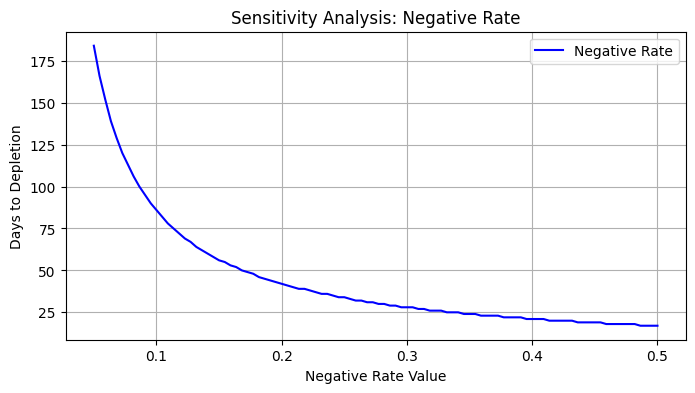

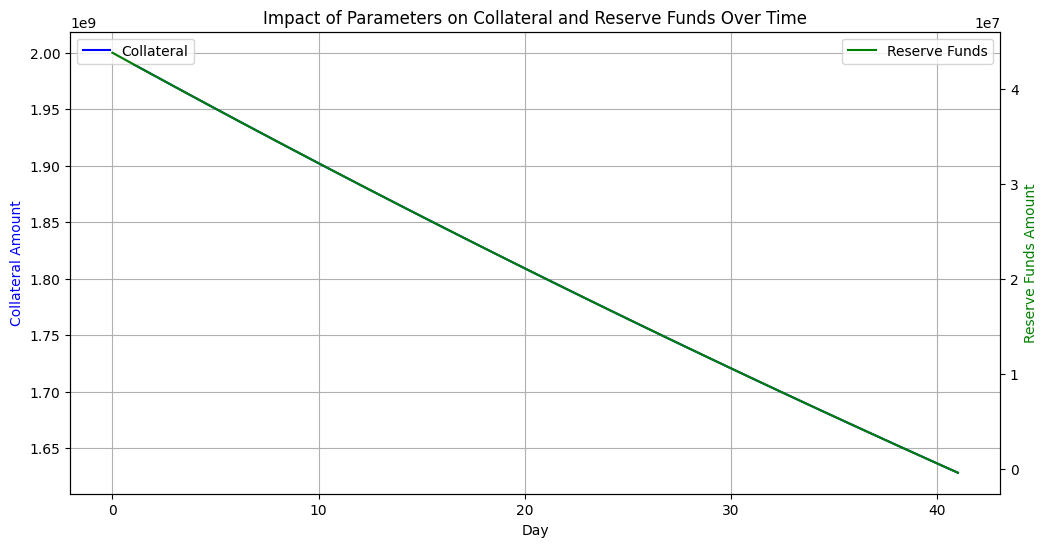

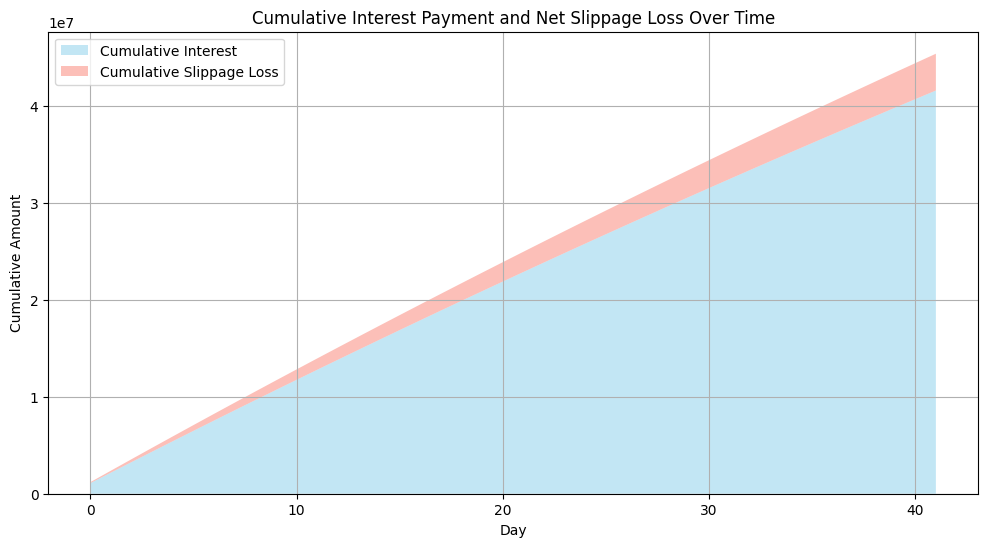

In [77]:
def simulate_financial_assumptions_exponential_decay(collateral, reserve_funds, negative_rate, slippage_loss, daily_redemption_rate, limit=365):
    data = []
    day = 0
    
    while collateral > 0 and reserve_funds > 0 and day <= limit:
        interest = collateral * negative_rate / 365
        reserve_funds -= interest
        net_slippage_loss = collateral * daily_redemption_rate * slippage_loss
        reserve_funds -= net_slippage_loss
        new_collateral = collateral * (1 - daily_redemption_rate)
        
        data.append({
            'day': day,
            'collateral': collateral,
            'reserve_funds': reserve_funds,
            'interest_payment': interest,
            'net_slippage_loss': net_slippage_loss
        })
        
        collateral = new_collateral
        day += 1
        
    return pd.DataFrame(data)

def simulate_financial_assumptions_linear_decay(collateral, reserve_funds, negative_rate, slippage_loss, daily_redemption_rate, limit=365):
    data = []
    day = 0
    redeem_collateral = collateral * daily_redemption_rate
    
    while collateral > 0 and reserve_funds > 0 and day <= limit:
        interest = collateral * negative_rate / 365
        reserve_funds -= interest
        net_slippage_loss = collateral * daily_redemption_rate * slippage_loss
        reserve_funds -= net_slippage_loss
        new_collateral = collateral - redeem_collateral
        
        data.append({
            'day': day,
            'collateral': collateral,
            'reserve_funds': reserve_funds,
            'interest_payment': interest,
            'net_slippage_loss': net_slippage_loss
        })
        
        collateral = new_collateral
        day += 1
        
    return pd.DataFrame(data)

def sensitivity_analysis(base_params, param_ranges, simulation_function, num_steps=100):
    results = []
    for value in np.linspace(param_ranges['negative_rate'][0], param_ranges['negative_rate'][1], num_steps):
        params = base_params.copy()
        params['negative_rate'] = value
        df = simulation_function(**params)
        results.append({
            'param': 'negative_rate',
            'value': value,
            'days_to_depletion': len(df)
        })
    return pd.DataFrame(results)


# Define the base parameters for the simulations
base_params = {
    'collateral': 2000000000,
    'reserve_funds': 45000000,
    'negative_rate': 0.2,
    'slippage_loss': 0.01,
    'daily_redemption_rate': 0.005
}

# Select which simulation function to use
    # simulate_financial_assumptions_linear_decay
    # simulate_financial_assumptions_exponential_decay
selected_simulation_function = simulate_financial_assumptions_exponential_decay

# Run the selected simulation function
df = selected_simulation_function(**base_params)

# Sensitivity analysis for negative rate
param_ranges = {'negative_rate': (0.05, 0.5)}
sensitivity_results = sensitivity_analysis(base_params, param_ranges, selected_simulation_function)

# Plot the results of the sensitivity analysis
plt.figure(figsize=(8, 4))
plt.plot(sensitivity_results['value'], sensitivity_results['days_to_depletion'], label='Negative Rate', color='blue')
plt.title('Sensitivity Analysis: Negative Rate')
plt.xlabel('Negative Rate Value')
plt.ylabel('Days to Depletion')
plt.legend()
plt.grid(True)
plt.show()

# Additional plotting to show the impact of parameters on collateral and reserve funds
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.plot(df['day'], df['collateral'], label='Collateral', color='blue')
ax1.set_title('Impact of Parameters on Collateral and Reserve Funds Over Time')
ax1.set_xlabel('Day')
ax1.set_ylabel('Collateral Amount', color='blue')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df['day'], df['reserve_funds'], label='Reserve Funds', color='green')
ax2.set_ylabel('Reserve Funds Amount', color='green')
ax2.legend(loc='upper right')

plt.show()

# Show cumulative interest and slippage loss over time
df['cumulative_interest'] = df['interest_payment'].cumsum()
df['cumulative_slippage_loss'] = df['net_slippage_loss'].cumsum()
plt.figure(figsize=(12, 6))
plt.stackplot(df['day'], df['cumulative_interest'], df['cumulative_slippage_loss'], 
              labels=['Cumulative Interest', 'Cumulative Slippage Loss'],
              colors=['skyblue', 'salmon'], alpha=0.5)
plt.title('Cumulative Interest Payment and Net Slippage Loss Over Time')
plt.xlabel('Day')
plt.ylabel('Cumulative Amount')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


## Monte Carlo Sim

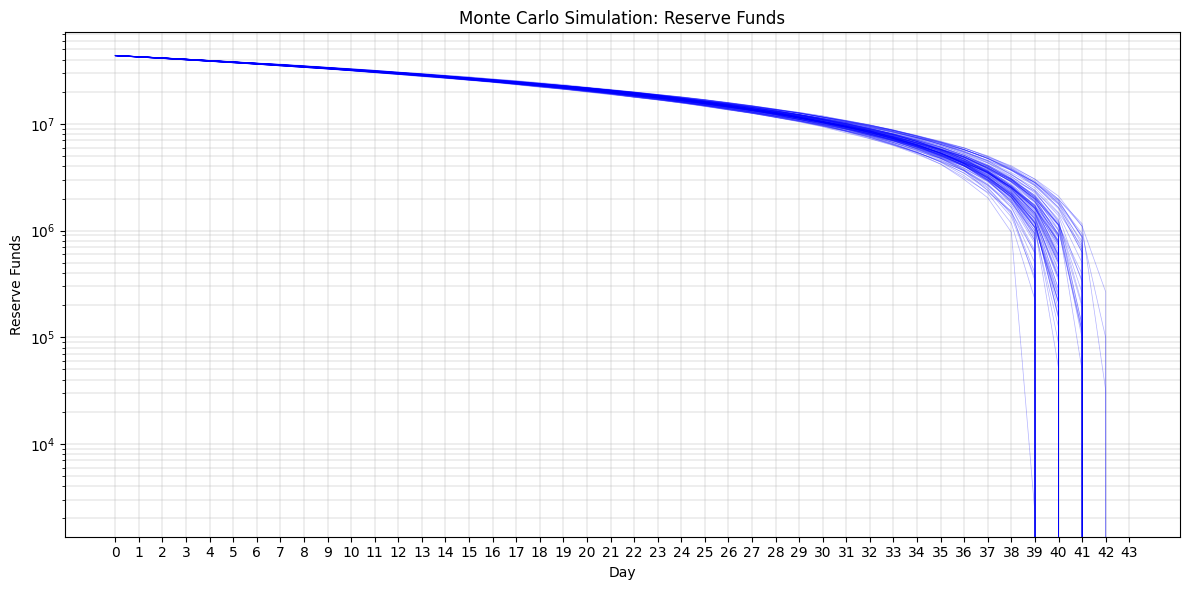

Sensitivity analysis completed. Total rows: 300


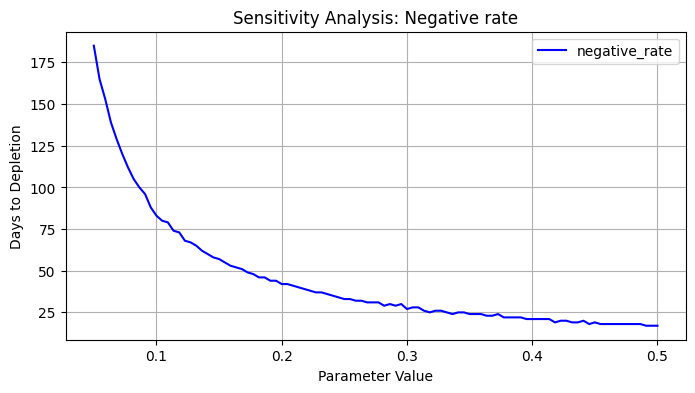

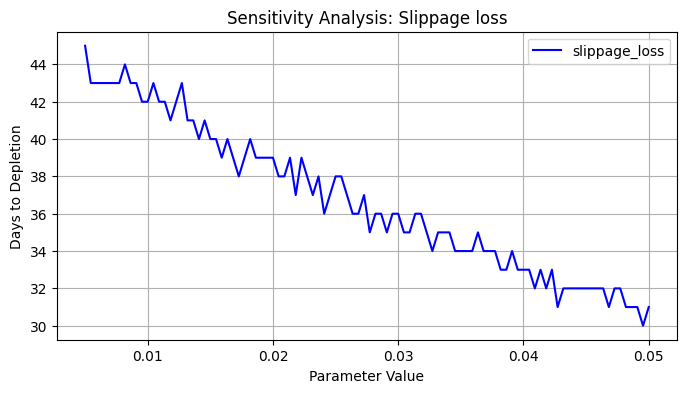

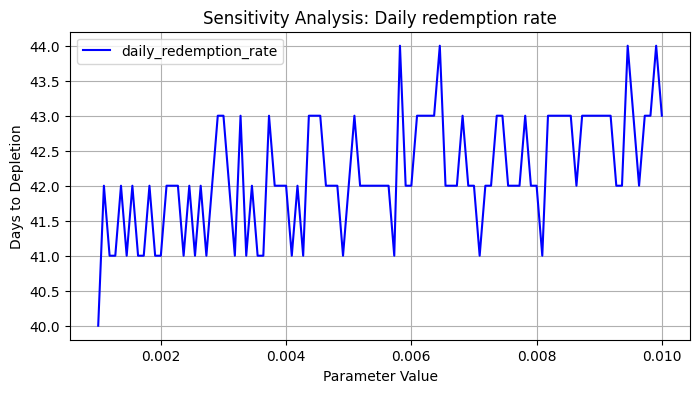

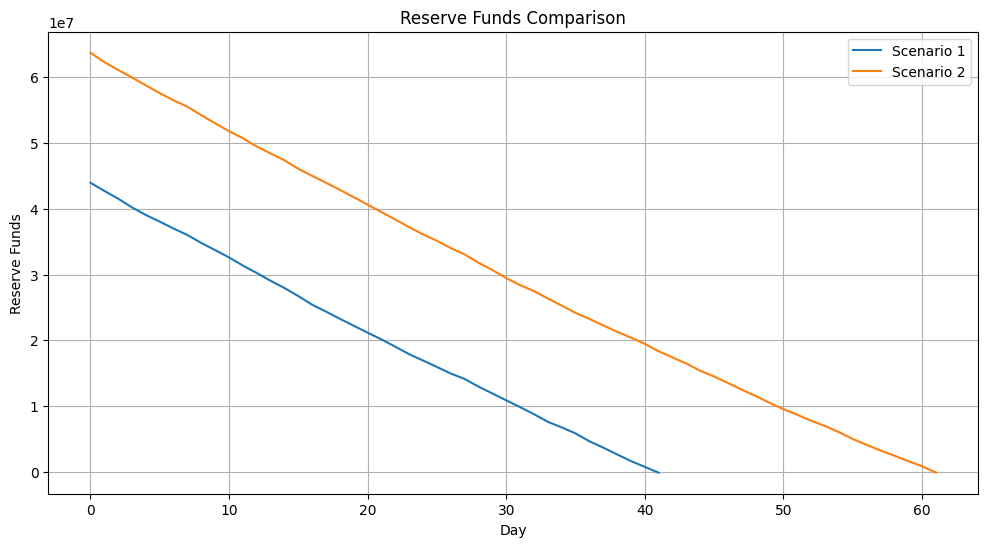

In [79]:
def simulate_financial_assumptions(collateral, reserve_funds, negative_rate, slippage_loss, daily_redemption_rate, days=365, volatility=0.07):
    """
    Simulates financial metrics over a given number of days under specified assumptions.
    Args:
        collateral (float): Initial amount of collateral.
        reserve_funds (float): Initial amount of reserve funds.
        negative_rate (float): Annual negative interest rate applied to the collateral.
        slippage_loss (float): Proportion of the collateral lost to slippage per day.
        daily_redemption_rate (float): Daily rate at which collateral is redeemed.
        days (int): Number of days to simulate.
        volatility (float): Volatility factor for rates, affecting daily randomness.

    Returns:
        DataFrame: A DataFrame containing the simulation results per day.
    """
    data = []
    for day in range(days):
        if collateral <= 0 or reserve_funds <= 0:
            break
        
        daily_negative_rate = negative_rate * (1 + np.random.normal(0, volatility))
        daily_slippage = slippage_loss * (1 + np.random.normal(0, volatility))
        daily_redemption = daily_redemption_rate * (1 + np.random.normal(0, volatility))
        
        interest = collateral * daily_negative_rate / 365
        reserve_funds -= interest
        new_collateral = collateral * (1 - daily_redemption)
        net_slippage_loss = collateral * daily_redemption * daily_slippage
        reserve_funds -= net_slippage_loss
        
        data.append({
            'day': day,
            'collateral': collateral,
            'reserve_funds': reserve_funds,
            'interest_payment': interest,
            'net_slippage_loss': net_slippage_loss
        })
        
        collateral = new_collateral
            
    return pd.DataFrame(data)

def monte_carlo_simulation(num_simulations, **kwargs):
    """
    Perform multiple Monte Carlo simulations.
    Args:
        num_simulations (int): Number of simulations to run.
        **kwargs: Parameters passed to the simulation function.
    
    Returns:
        DataFrame: A concatenated DataFrame containing results from all simulations.
    """
    all_simulations = []
    for _ in range(num_simulations):
        df = simulate_financial_assumptions(**kwargs)
        df['simulation'] = _
        all_simulations.append(df)
    return pd.concat(all_simulations)

def sensitivity_analysis(base_params, param_ranges, num_steps=100):
    """
    Conducts sensitivity analysis over a range of parameter values.
    Args:
        base_params (dict): Base parameters for the simulation.
        param_ranges (dict): Dictionary specifying the parameter ranges.
        num_steps (int): Number of steps to take within each range.

    Returns:
        DataFrame: Results of the sensitivity analysis.
    """
    results = []
    for param, (start, end) in param_ranges.items():
        for value in np.linspace(start, end, num_steps):
            params = base_params.copy()
            params[param] = value
            df = simulate_financial_assumptions(**params)
            results.append({
                'param': param,
                'value': value,
                'days_to_depletion': len(df)
            })
    return pd.DataFrame(results)

def calculate_risk_metrics(df):
    """
    Calculates the Value at Risk (VaR) and Expected Shortfall (ES) for the reserve funds.
    Args:
        df (DataFrame): DataFrame containing simulation results.
    
    Returns:
        dict: Dictionary containing VaR and ES metrics.
    """
    initial_reserve = df['reserve_funds'].iloc[0]
    var_95 = np.percentile(df['reserve_funds'], 5) - initial_reserve
    es_95 = df[df['reserve_funds'] <= np.percentile(df['reserve_funds'], 5)]['reserve_funds'].mean() - initial_reserve
    return {'VaR_95': var_95, 'ES_95': es_95}

def compare_scenarios(scenario1, scenario2):
    """
    Compares two financial scenarios by plotting their reserve funds over time.
    Args:
        scenario1 (dict): Parameters for the first scenario.
        scenario2 (dict): Parameters for the second scenario.
    """
    df1 = simulate_financial_assumptions(**scenario1)
    df2 = simulate_financial_assumptions(**scenario2)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df1['day'], df1['reserve_funds'], label='Scenario 1')
    plt.plot(df2['day'], df2['reserve_funds'], label='Scenario 2')
    plt.title('Reserve Funds Comparison')
    plt.xlabel('Day')
    plt.ylabel('Reserve Funds')
    plt.legend()
    plt.grid(True)
    plt.show()


base_params = {
    'collateral': 2000000000,
    'reserve_funds': 45000000,
    'negative_rate': 0.2,
    'slippage_loss': 0.01,
    'daily_redemption_rate': 0.005,
    'volatility': 0.1
}

# Run Monte Carlo simulation
mc_results = monte_carlo_simulation(100, **base_params)

# print(f"Monte Carlo simulation completed. Total rows: {len(mc_results)}")
# print(f"Number of unique simulations: {mc_results['simulation'].nunique()}")
# print(f"Average days per simulation: {len(mc_results) / mc_results['simulation'].nunique()}")


# Plot Monte Carlo results
plt.figure(figsize=(12, 6))
for sim in mc_results['simulation'].unique():
    df = mc_results[mc_results['simulation'] == sim]
    plt.plot(df['day'], df['reserve_funds'], alpha=0.3, linewidth='0.5',color='blue')

plt.title('Monte Carlo Simulation: Reserve Funds')
plt.xlabel('Day')
plt.ylabel('Reserve Funds')
plt.yscale('log')  # Use log scale for y-axis

# Set major and minor grid lines
plt.grid(True, which='both', linestyle='-', linewidth='0.3')

# Set x-axis to show grid lines for each day
plt.xticks(np.arange(min(mc_results['day']), max(mc_results['day'])+1, 1.0))  # Adjust as necessary based on your data

plt.tight_layout()
plt.show()


# Sensitivity analysis
param_ranges = {
    'negative_rate': (0.05, 0.5),
    'slippage_loss': (0.005, 0.05),
    'daily_redemption_rate': (0.001, 0.01)
}
sensitivity_results = sensitivity_analysis(base_params, param_ranges)

print(f"Sensitivity analysis completed. Total rows: {len(sensitivity_results)}")


# Plotting individual sensitivity analysis results for each parameter
for param in param_ranges.keys():
    plt.figure(figsize=(8, 4))
    df = sensitivity_results[sensitivity_results['param'] == param]
    plt.plot(df['value'], df['days_to_depletion'], label=f'{param}', color='blue')
    plt.title(f'Sensitivity Analysis: {param.capitalize().replace("_", " ")}')
    plt.xlabel('Parameter Value')
    plt.ylabel('Days to Depletion')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare scenarios
scenario1 = base_params.copy()
scenario2 = base_params.copy()
scenario2['reserve_funds'] = 65000000 # Insert new value for reserve funds recomeendation
compare_scenarios(scenario1, scenario2)


## Dump

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def simulate_financial_assumptions(collateral, reserve_funds, negative_rate, slippage_loss, daily_redemption_rate, limit=365):
#     day = 0
#     data = []
    
#     # redeem_collateral = collateral * daily_redemption_rate
    
#     while collateral > 0 and reserve_funds > 0:
#         interest = collateral * negative_rate / 365
#         reserve_funds -= interest
#         new_collateral = collateral * (1 - daily_redemption_rate)
#         # new_collateral = collateral - redeem_collateral
#         net_slippage_loss = collateral * daily_redemption_rate * slippage_loss
#         reserve_funds -= net_slippage_loss
        
#         data.append({
#             'day': day,
#             'collateral': collateral,
#             'reserve_funds': reserve_funds,
#             'interest_payment': interest,
#             'net_slippage_loss': net_slippage_loss
#         })
        
#         collateral = new_collateral
#         day += 1
        
#         if reserve_funds < 0 or collateral < 0:
#             break
        
#         if day > limit:
#             break
        
#     df = pd.DataFrame(data)
    
#     return df

# def sensitivity_analysis(base_params, param_ranges, num_steps=100):
#     results = []
#     for param, (start, end) in param_ranges.items():
#         for value in np.linspace(start, end, num_steps):
#             params = base_params.copy()
#             params[param] = value
#             df = simulate_financial_assumptions(**params)
#             results.append({
#                 'param': param,
#                 'value': value,
#                 'days_to_depletion': len(df)
#             })
#     return pd.DataFrame(results)

# base_params = {
#     'collateral': 2000000000,
#     'reserve_funds': 45000000,
#     'negative_rate': 0.2,
#     'slippage_loss': 0.01,
#     'daily_redemption_rate': 0.05
# }
# # Example usage
# df = simulate_financial_assumptions(**base_params)

# # Create the figure and the first axes (ax1)
# plt.figure(figsize=(12, 6))
# ax1 = plt.gca()  # Get current axes
# ax1.plot(df['day'], df['collateral'], label='Collateral', color='blue')
# ax1.set_title('Impact of Parameters on Collateral and Reserve Funds Over Time')
# ax1.set_xlabel('Day')
# ax1.set_ylabel('Collateral Amount', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.legend(loc='upper left')
# ax1.grid(True)

# # Create a second axes (ax2) for the reserve funds
# ax2 = ax1.twinx()  # Create a second y-axis
# ax2.plot(df['day'], df['reserve_funds'], label='Reserve Funds', color='green')
# ax2.set_ylabel('Reserve Funds Amount', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper right')

# plt.show()

# df['cumulative_interest'] = df['interest_payment'].cumsum()
# df['cumulative_slippage_loss'] = df['net_slippage_loss'].cumsum()

# plt.figure(figsize=(12, 6))
# plt.stackplot(df['day'], df['cumulative_interest'], df['cumulative_slippage_loss'], 
#               labels=['Cumulative Interest', 'Cumulative Slippage Loss'],
#               colors=['skyblue', 'salmon'], alpha=0.5)
# plt.title('Cumulative Interest Payment and Net Slippage Loss Over Time')
# plt.xlabel('Day')
# plt.ylabel('Cumulative Amount')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.show()
    
# # Sensitivity analysis
# param_ranges = {
#     'negative_rate': (0.05, 0.5)
# }
# sensitivity_results = sensitivity_analysis(base_params, param_ranges)

# print(f"Sensitivity analysis completed. Total rows: {len(sensitivity_results)}")

# # Plotting individual sensitivity analysis results for each parameter
# for param in param_ranges.keys():
#     plt.figure(figsize=(8, 4))
#     df = sensitivity_results[sensitivity_results['param'] == param]
#     plt.plot(df['value'], df['days_to_depletion'], label=f'{param}', color='blue')
#     plt.title(f'Sensitivity Analysis: {param.capitalize().replace("_", " ")}')
#     plt.xlabel('Parameter Value')
#     plt.ylabel('Days to Depletion')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def simulate_financial_assumptions(
#     collateral,
#     reserve_funds,
#     negative_rate,
#     slippage_loss,
#     daily_redemption_rate
# ):
#     day = 0
#     data = []
    
#     redeem_collateral = collateral * daily_redemption_rate
    
#     while collateral > 0 and reserve_funds > 0:
#         interest = collateral * negative_rate / 365
#         reserve_funds -= interest
#         # new_collateral = collateral * (1 - daily_redemption_rate)
#         new_collateral = collateral - redeem_collateral
#         net_slippage_loss = collateral * daily_redemption_rate * slippage_loss
#         reserve_funds -= net_slippage_loss
        
#         data.append({
#             'day': day,
#             'collateral': collateral,
#             'reserve_funds': reserve_funds,
#             'interest_payment': interest,
#             'net_slippage_loss': net_slippage_loss
#         })
        
#         collateral = new_collateral
#         day += 1
        
#         if reserve_funds < 0 or collateral < 0:
#             break
    
#     return pd.DataFrame(data)


# def sensitivity_analysis(base_params, param_ranges, num_steps=100):
#     results = []
#     for value in np.linspace(param_ranges['negative_rate'][0], param_ranges['negative_rate'][1], num_steps):
#         params = base_params.copy()
#         params['negative_rate'] = value
#         df = simulate_financial_assumptions(**params)
#         results.append({
#             'param': 'negative_rate',
#             'value': value,
#             'days_to_depletion': len(df)
#         })
#     return pd.DataFrame(results)

# def collateral_depletion(collateral,daily_redemption_rate):
#     if daily_redemption_rate <= 0:
#         print("infinity")
#         return 0
#     else:
#         redeem_collateral = collateral * daily_redemption_rate
#         day = 0
#         data = []
        
#         while collateral > 0:
#             new_collateral = collateral - redeem_collateral
            
#             data.append({
#                 'day': day,
#                 'collateral': collateral
#             })
            
#             collateral = new_collateral
#             day += 1
            
#         output_df = pd.DataFrame(data)    
#         print(len(output_df))
#         return output_df
    


# base_params = {
#     'collateral': 2000000000,
#     'reserve_funds': 45000000,
#     'negative_rate': 0.2,
#     'slippage_loss': 0.01,
#     'daily_redemption_rate': 0.01
# }

# depletion_days = collateral_depletion(base_params['collateral'], base_params['daily_redemption_rate'])

# # Sensitivity analysis for negative rate
# param_ranges = {
#     'negative_rate': (0.05, 0.5)
# }
# sensitivity_results = sensitivity_analysis(base_params, param_ranges)

# print(f"Sensitivity analysis completed. Total rows: {len(sensitivity_results)}")

# # Plotting the sensitivity analysis results for negative rate
# plt.figure(figsize=(8, 4))
# plt.plot(sensitivity_results['value'], sensitivity_results['days_to_depletion'], label='Negative Rate', color='blue')
# plt.title('Sensitivity Analysis: Negative Rate')
# plt.xlabel('Negative Rate Value')
# plt.ylabel('Days to Depletion')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Example usage
# df = simulate_financial_assumptions(**base_params)

# # Create the figure and the first axes (ax1)
# plt.figure(figsize=(12, 6))
# ax1 = plt.gca()  # Get current axes
# ax1.plot(df['day'], df['collateral'], label='Collateral', color='blue')
# ax1.set_title('Impact of Parameters on Collateral and Reserve Funds Over Time')
# ax1.set_xlabel('Day')
# ax1.set_ylabel('Collateral Amount', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.legend(loc='upper left')
# ax1.grid(True)

# # Create a second axes (ax2) for the reserve funds
# ax2 = ax1.twinx()  # Create a second y-axis
# ax2.plot(df['day'], df['reserve_funds'], label='Reserve Funds', color='green')
# ax2.set_ylabel('Reserve Funds Amount', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper right')

# plt.show()

# df['cumulative_interest'] = df['interest_payment'].cumsum()
# df['cumulative_slippage_loss'] = df['net_slippage_loss'].cumsum()


# plt.figure(figsize=(12, 6))
# plt.stackplot(df['day'], df['cumulative_interest'], df['cumulative_slippage_loss'], 
#               labels=['Cumulative Interest', 'Cumulative Slippage Loss'],
#               colors=['skyblue', 'salmon'], alpha=0.5)
# plt.title('Cumulative Interest Payment and Net Slippage Loss Over Time')
# plt.xlabel('Day')
# plt.ylabel('Cumulative Amount')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.show()